## To Do

- Additional manual, spot-checking of ICD & CPT code category cuts. 
- Consider whether we want to expand on "mg" to things like "mcg" etc. for RxNorm API calls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import config
import api_rxnorm
import DatasetCreation
import helper as hlpr

# Load Data

In [3]:
dir = '../data/'
prefix = 'FONNESBECK_'
suffix = '_20151202.csv'

In [4]:
adt = pd.read_csv(dir + prefix + 'ADT' + suffix, encoding='latin1')
adt.columns = adt.columns.str.lower()
adt.head()

,ruid,event,admission_date,event_date,srv_code,chief_complaint,discharge_date
0,50135262,Admit,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
1,50135262,Transfer,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
2,50135262,Transfer,02/08/2007,02/09/2007,ORT,R FEMUR FX,02/12/2007
3,50135262,Discharge,02/08/2007,02/12/2007,ORT,R FEMUR FX,02/12/2007
4,50135262,Transfer,02/11/2011,02/11/2011,NEU,SEIZURES;HYPERGLYCEMIA,02/23/2011


In [5]:
adt_cms_final = pd.read_pickle(dir + './adt_cms_final.pkl')
adt_cms_final.head()

,ruid,visit_id,admit_date,discharge_date,hospital_day,stay_length,n_transfers,readmit_time,readmit_30d
0,50135262,0,2007-02-08,2007-02-12,2007-02-08,4 days,2,NaT,0
1,50135262,0,2007-02-08,2007-02-12,2007-02-09,4 days,2,NaT,0
2,50135262,0,2007-02-08,2007-02-12,2007-02-10,4 days,2,NaT,0
3,50135262,0,2007-02-08,2007-02-12,2007-02-11,4 days,2,NaT,0
4,50135262,0,2007-02-08,2007-02-12,2007-02-12,4 days,2,NaT,0


In [6]:
cpt = pd.read_csv(dir + prefix + 'CPT' + suffix)
cpt.columns = cpt.columns.str.lower()
cpt.head()

,ruid,cpt_code,event_date
0,50135262,00001,11/28/2004
1,50135262,00005,05/03/2012
2,50135262,00025,02/08/2007
3,50135262,00025,11/16/2004
4,50135262,00030,02/08/2007


In [7]:
icd = pd.read_csv(dir + prefix + 'ICD9' + suffix)
icd.columns = icd.columns.str.lower()
icd.head()

,ruid,icd9_code,event_date
0,50135262,00.40,08/04/2007
1,50135262,00.46,08/04/2007
2,50135262,00.66,08/04/2007
3,50135262,00.81,09/17/2012
4,50135262,00.82,09/17/2012


In [8]:
# can't get this to work (Alvin)
#lab = pd.read_csv(dir + prefix + 'LAB' + suffix) # engine='python' produces a different error
#lab.head()

# I have no trouble opening it in R
#library(data.table)
#df <- fread('/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB_20151202.csv')
#write.csv(df, file = '/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB2_20151202.csv')

In [9]:
med = pd.read_csv(dir + prefix + 'MED' + suffix)
med.columns = med.columns.str.lower()

# sort values to assist with duplicate removal later
med.sort_values(by=['ruid', 'entry_date', 'drug_name', 'dose_amt'], inplace=True)
med.head()

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN


In [10]:
phenotype = pd.read_csv(dir + prefix + 'phenotype' + suffix, parse_dates=['DOB', 'DOD'])
phenotype.columns = phenotype.columns.str.lower()
phenotype.head()

,ruid,sex,dob,dod,race
0,50135262,F,1949-09-20,NaT,W
1,50135361,M,1932-02-15,2012-09-09,W
2,50135369,M,1958-05-04,2012-01-23,W
3,50135375,M,1943-05-01,2011-08-18,B
4,50135425,F,1946-10-02,NaT,W


# Phenotype

In [11]:
phenotype.describe(include='all')

,ruid,sex,dob,dod,race
count,8.000000e+03,7957,7957,1358,8000
unique,NaN,3,7049,1119,7
top,NaN,F,1955-03-06 00:00:00,2014-02-22 00:00:00,W
freq,NaN,3986,4,5,5999
first,NaN,NaN,1903-04-17 00:00:00,2004-08-19 00:00:00,NaN
last,NaN,NaN,2014-11-15 00:00:00,2015-06-25 00:00:00,NaN
mean,5.369131e+07,NaN,NaN,NaN,NaN
std,3.663645e+05,NaN,NaN,NaN,NaN
min,5.013526e+07,NaN,NaN,NaN,NaN
25%,5.372991e+07,NaN,NaN,NaN,NaN


In [12]:
uniq = len(np.unique(phenotype.ruid))

print("Shape of phenotype = {shape}. Unique RUIDs = {uniq}.".format(
    shape=phenotype.shape, uniq=uniq))

Shape of phenotype = (8000, 5). Unique RUIDs = 8000.


In [13]:
females = sum(phenotype.sex=='F')
males = sum(phenotype.sex=='M')
unknown = sum(phenotype.sex=='U')
miss = phenotype.sex.isnull().sum()
assert(females + males + unknown + miss == uniq)

print("Females = {f}, Males = {m}, Unknown = {u}, NA = {na}".format(
  f=females, m=males, u=unknown, na=miss))

Females = 3986, Males = 3953, Unknown = 18, NA = 43


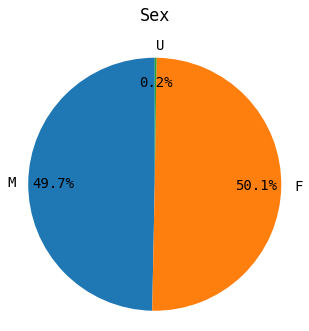

In [15]:
hlpr.pie_chart(['M', 'F', 'U'], phenotype, 'sex', 'Sex', figsize=(5, 5))

In [16]:
asian = sum(phenotype.race=='A')
black = sum(phenotype.race=='B')
hispanic = sum(phenotype.race=='H')
indian = sum(phenotype.race=='I')
other = sum(phenotype.race=='N')
unknown = sum(phenotype.race=='U')
white = sum(phenotype.race=='W')
assert(asian + black + hispanic + indian + other + unknown + white == uniq)

print("Asian = {a}, Black = {b}, Hispanice = {h}, American Indian = {i}, Other = {n}, Unknown = {u}, White = {w}".format( \
  a=asian, b=black, h=hispanic, i=indian, n=other, u=unknown, w=white))

Asian = 94, Black = 1193, Hispanice = 315, American Indian = 8, Other = 50, Unknown = 341, White = 5999


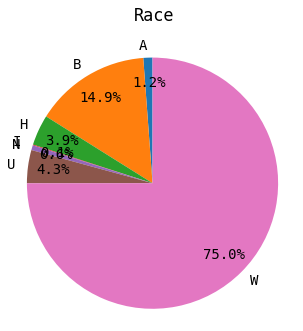

In [18]:
hlpr.pie_chart(['A', 'B', 'H', 'I', 'N', 'U', 'W'], phenotype, 'race', 'Race', figsize=(5, 5))

In [19]:
# missing DOB or sex
potential_removal = phenotype[phenotype.dob.isnull() | phenotype.sex.isnull()]
potential_removal

,ruid,sex,dob,dod,race
138,53727820,NaN,NaT,NaT,U
363,53728072,NaN,NaT,NaT,U
537,53728274,NaN,NaT,NaT,U
711,53728472,NaN,NaT,NaT,U
811,53728579,NaN,NaT,NaT,U
832,53728602,NaN,NaT,NaT,U
906,53728684,NaN,NaT,NaT,U
955,53728740,NaN,NaT,NaT,U
1192,53729008,NaN,NaT,NaT,U
1318,53729141,NaN,NaT,NaT,U


In [20]:
potential_removal.shape

(43, 5)

In [21]:
phenotype.to_pickle(dir + './phenotype.pkl')

# ICD Codes

In [22]:
uniq = len(np.unique(icd.ruid))
codes = set(icd.icd9_code)

print("Shape of ICD = {shape}. Unique RUIDs = {uniq}. Unique ICD9 Codes = {codes}.".format(
    shape=icd.shape, uniq=uniq, codes=len(codes)))

Shape of ICD = (2052067, 3). Unique RUIDs = 7935. Unique ICD9 Codes = 12423.


In [23]:
# create a new column of numeric version of codes, making strings NaN
icd['code_num'] = pd.to_numeric(icd.icd9_code, errors='coerce')

In [24]:
icd['code_cat'] = pd.cut(icd.code_num, bins=[0, 1, 140, 240, 280, 290, 320, 
                                              390, 460, 520, 580, 630, 
                                              680, 710, 740, 760, 780, 800, 1000], 
                         right=False, # closed on the left, non-inclusive on the right
                         labels=['proc', 'dx_infection', 'dx_neoplasm', 'dx_endocrine', 'dx_blood', 'dx_mental', 'dx_nervous', 
                                 'dx_circulatory', 'dx_respiratory', 'dx_digestive', 'dx_gu', 'dx_obstetric', 
                                 'dx_skin', 'dx_muscskel', 'dx_congenital', 'dx_perinatal', 'dx_symptoms', 'dx_injury'])

icd.code_cat = np.where(icd.icd9_code.str.contains('V'), 'visit', icd.code_cat)
icd.code_cat = np.where(icd.icd9_code.str.contains('E'), 'dx_external', icd.code_cat)

In [25]:
icd.head()

,ruid,icd9_code,event_date,code_num,code_cat
0,50135262,00.40,08/04/2007,0.40,proc
1,50135262,00.46,08/04/2007,0.46,proc
2,50135262,00.66,08/04/2007,0.66,proc
3,50135262,00.81,09/17/2012,0.81,proc
4,50135262,00.82,09/17/2012,0.82,proc


In [26]:
icd.tail()

,ruid,icd9_code,event_date,code_num,code_cat
2052062,53736423,77,04/25/2006,77.0,dx_infection
2052063,53736423,774.6,04/23/2006,774.6,dx_perinatal
2052064,53736423,V30.00,04/23/2006,NaN,visit
2052065,53736423,V50.2,04/23/2006,NaN,visit
2052066,53736423,V50.2,04/24/2006,NaN,visit


In [27]:
dx_dict = {}
for dx in set(icd.code_cat):
    dx_dict[dx] = sum(icd.code_cat==str(dx))

assert(sum(dx_dict.values()) == icd.shape[0])

In [28]:
dx_dict

{'dx_nervous': 86283,
 'dx_muscskel': 100649,
 'dx_infection': 145279,
 'dx_endocrine': 162164,
 'visit': 255132,
 'dx_perinatal': 24061,
 'dx_circulatory': 226565,
 'dx_injury': 78319,
 'dx_skin': 26707,
 'dx_respiratory': 109354,
 'proc': 38203,
 'dx_blood': 76572,
 'dx_mental': 79404,
 'dx_congenital': 34379,
 'dx_symptoms': 283718,
 'dx_gu': 95505,
 'dx_neoplasm': 108924,
 'dx_external': 13521,
 'dx_obstetric': 19746,
 'dx_digestive': 87582}

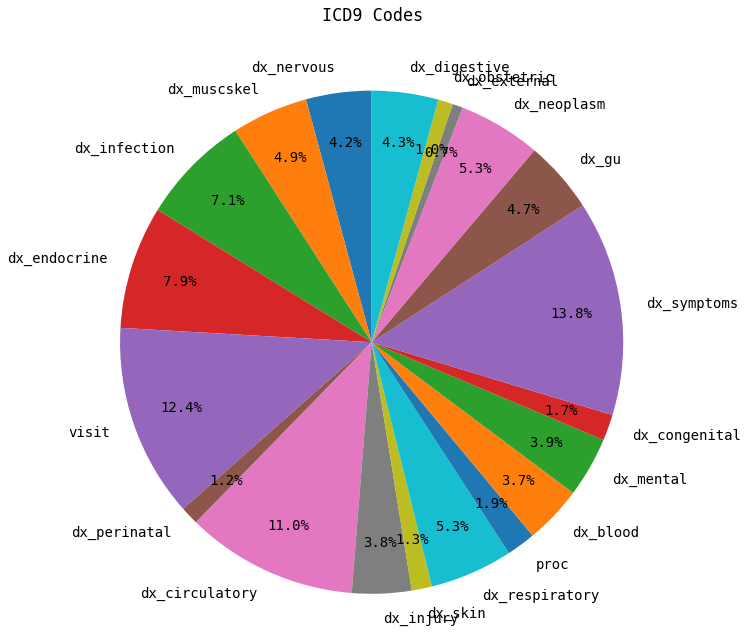

In [30]:
hlpr.pie_chart(dx_dict.keys(), icd, 'code_cat', 'ICD9 Codes', figsize = (10, 10))

In [31]:
# add counts of ICD9 categories for each day/patient combination
icd_wide = icd.copy()
icd_wide = (icd_wide.drop(columns=['icd9_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

In [32]:
# add 'icd_' prefix to all columns
cols = icd_wide.columns[~icd_wide.columns.str.contains('ruid|event_date')]
icd_wide.rename(columns = dict(zip(cols, 'icd_' + cols)), inplace=True)
icd_wide.head()

code_cat             icd_dx_blood  icd_dx_circulatory  icd_dx_congenital  \
ruid     event_date                                                        
50135262 01/09/2005           0.0                 0.0                0.0   
         02/08/2007           0.0                 2.0                0.0   
         02/09/2007           0.0                 2.0                0.0   
         02/10/2007           0.0                 0.0                0.0   
         02/11/2007           0.0                 0.0                0.0   

code_cat             icd_dx_digestive  icd_dx_endocrine  icd_dx_external  \
ruid     event_date                                                        
50135262 01/09/2005               0.0               0.0              0.0   
         02/08/2007               0.0               3.0              1.0   
         02/09/2007               0.0               1.0              0.0   
         02/10/2007               0.0               1.0              0.0   
         02/11/2007               0.0               1.0              0.0   

code_cat             icd_dx_gu  icd_dx_infection  icd_dx_injury  \
ruid     event_date                                               
50135262 01/09/2005        0.0               0.0            0.0   
         02/08/2007        0.0               2.0            5.0   
         02/09/2007        0.0               2.0            4.0   
         02/10/2007        0.0               0.0            0.0   
         02/11/2007        0.0               0.0            0.0   

code_cat             icd_dx_mental  icd_dx_muscskel  icd_dx_neoplasm  \
ruid     event_date                                                    
50135262 01/09/2005            0.0              0.0              0.0   
         02/08/2007            0.0              1.0              0.0   
         02/09/2007            0.0              0.0              0.0   
         02/10/2007            0.0              0.0              0.0   
         02/11/2007            0.0              0.0              0.0   

code_cat             icd_dx_nervous  icd_dx_obstetric  icd_dx_perinatal  \
ruid     event_date                                                       
50135262 01/09/2005             0.0               0.0               0.0   
         02/08/2007             1.0               0.0               0.0   
         02/09/2007             0.0               0.0               0.0   
         02/10/2007             0.0               0.0               0.0   
         02/11/2007             0.0               0.0               0.0   

code_cat             icd_dx_respiratory  icd_dx_skin  icd_dx_symptoms  \
ruid     event_date                                                     
50135262 01/09/2005                 0.0          0.0              1.0   
         02/08/2007                 1.0          0.0              3.0   
         02/09/2007                 0.0          0.0              0.0   
         02/10/2007                 0.0          0.0              2.0   
         02/11/2007                 0.0          0.0              0.0   

code_cat             icd_proc  icd_visit  
ruid     event_date                       
50135262 01/09/2005       0.0        0.0  
         02/08/2007       0.0        4.0  
         02/09/2007       0.0        2.0  
         02/10/2007       0.0        0.0  
         02/11/2007       0.0        0.0

In [33]:
icd_wide.reset_index(inplace=True)
icd_wide.head()

code_cat,ruid,event_date,icd_dx_blood,icd_dx_circulatory,icd_dx_congenital,icd_dx_digestive,icd_dx_endocrine,icd_dx_external,icd_dx_gu,icd_dx_infection,...,icd_dx_muscskel,icd_dx_neoplasm,icd_dx_nervous,icd_dx_obstetric,icd_dx_perinatal,icd_dx_respiratory,icd_dx_skin,icd_dx_symptoms,icd_proc,icd_visit
0,50135262,01/09/2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50135262,02/08/2007,0.0,2.0,0.0,0.0,3.0,1.0,0.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,4.0
2,50135262,02/09/2007,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,50135262,02/10/2007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,50135262,02/11/2007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
icd_wide.tail()

code_cat,ruid,event_date,icd_dx_blood,icd_dx_circulatory,icd_dx_congenital,icd_dx_digestive,icd_dx_endocrine,icd_dx_external,icd_dx_gu,icd_dx_infection,...,icd_dx_muscskel,icd_dx_neoplasm,icd_dx_nervous,icd_dx_obstetric,icd_dx_perinatal,icd_dx_respiratory,icd_dx_skin,icd_dx_symptoms,icd_proc,icd_visit
574577,53736422,12/06/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574578,53736422,12/25/2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574579,53736423,04/23/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
574580,53736423,04/24/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
574581,53736423,04/25/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
icd_wide['event_date'] = pd.to_datetime(icd_wide['event_date'])

In [36]:
icd_wide.to_pickle(dir + 'icd_wide.pkl')

# CPT Codes

In [37]:
cpt.tail()

,ruid,cpt_code,event_date
3827383,53736423,86850,04/25/2006
3827384,53736423,86880,04/25/2006
3827385,53736423,86900,04/25/2006
3827386,53736423,86901,04/25/2006
3827387,53736423,90744,04/23/2006


In [38]:
uniq = len(np.unique(cpt.ruid))
codes = set(cpt.cpt_code)

print("Shape of CPT = {shape}. Unique RUIDs = {uniq}. Unique CPT Codes = {codes}.".format(
    shape=cpt.shape, uniq=uniq, codes=len(codes)))

Shape of CPT = (3827388, 3). Unique RUIDs = 7891. Unique CPT Codes = 7274.


In [39]:
# are any non-numeric CPT codes present - yes!
np.unique(cpt.cpt_code)

array([' J751', '00001', '00002', ..., 'V5363', 'V5364', 'Y1405'],
      dtype=object)

In [40]:
# create a new column of numeric version of codes, making strings NaN
cpt['code_num'] = pd.to_numeric(cpt.cpt_code, errors='coerce')

In [41]:
cpt['code_cat'] = pd.cut(cpt.code_num, bins=[0, 99, # expired codes
                                             100-0.01, 1999, # anethesia
                                             10000-0.01, 69990, # surgery
                                             70000-0.01, 79999, # radiology
                                             80000-0.01, 89398, # pathology & laboratory
                                             90281-0.01, 99099, # medicine
                                             99100-0.01, 99150, # anesthesia
                                             99151-0.01, 99199, # medicine
                                             99201-0.01, 99499, # evaluation & management
                                             99500-0.01, 99607, # medicine
                                             99608-0.01, 100000, # unknown2
                                             ],
                          # by default, it doesn't include value on the left, so -0.01 added
                          right=True, # inclusive on the right
                          # labels must be unique in the pandas cut() function
                          labels=['expired', 'gap0',
                                  'anesthesia1', 'gap1', 
                                  'surgery', 'gap2',
                                  'radiology', 'gap3', 
                                  'path_lab', 'gap4', 
                                  'medicine1', 'gap5',
                                  'anesthesia2', 'gap6',
                                  'medicine2', 'gap7',
                                  'eval_manage', 'gap8',
                                  'medicine3', 'gap9',
                                  'unknown1'
                                 ])

# remove numbers from labels
cpt.code_cat = cpt.code_cat.str.replace('\d+', '', regex=True)

# for Category 2 & 3 CPT codes (i.e., those that include a letter rather than all numbers), 
# marks as "modifier" (the CPT terminology), which are optional for billing purposes
cpt.code_cat = np.where(np.isnan(cpt.code_num), 'modifier', cpt.code_cat)

In [42]:
cpt.head()

,ruid,cpt_code,event_date,code_num,code_cat
0,50135262,00001,11/28/2004,1.0,expired
1,50135262,00005,05/03/2012,5.0,expired
2,50135262,00025,02/08/2007,25.0,expired
3,50135262,00025,11/16/2004,25.0,expired
4,50135262,00030,02/08/2007,30.0,expired


In [43]:
cpt.tail()

,ruid,cpt_code,event_date,code_num,code_cat
3827383,53736423,86850,04/25/2006,86850.0,path_lab
3827384,53736423,86880,04/25/2006,86880.0,path_lab
3827385,53736423,86900,04/25/2006,86900.0,path_lab
3827386,53736423,86901,04/25/2006,86901.0,path_lab
3827387,53736423,90744,04/23/2006,90744.0,medicine


In [44]:
# what are the 'unknown' values?
np.unique(cpt[cpt.code_cat=='unknown']['cpt_code'])

array(['99999'], dtype=object)

I couldn't find 99999 anywhere - perhaps this just means missing & should be removed?

In [45]:
# what are the 'gap' values?
np.unique(cpt[cpt.code_cat=='gap']['cpt_code'])

array(['01999.1', '01999.2', '01999.3', '01999.4', '01999.5', '01999.6',
       '01999.7', '01999.8', '89399', '9999'], dtype=object)

I've never seen decimal places in a CPT code, so we could either label these as modifiers or just remove them (similar to 9999, which isn't a correct CPT code as it only has 4 digits).  

In [46]:
# replace "gap" with unknown
cpt.code_cat = np.where(cpt.code_cat=='gap', 'unknown', cpt.code_cat)

In [47]:
code_dict = {}
for code in set(cpt.code_cat):
    code_dict[code] = sum(cpt.code_cat==str(code))

assert(sum(code_dict.values()) == cpt.shape[0])

code_dict

{'anesthesia': 6526,
 'eval_manage': 447503,
 'medicine': 474569,
 'expired': 81986,
 'surgery': 179513,
 'path_lab': 1813333,
 'radiology': 192170,
 'unknown': 5964,
 'modifier': 625824}

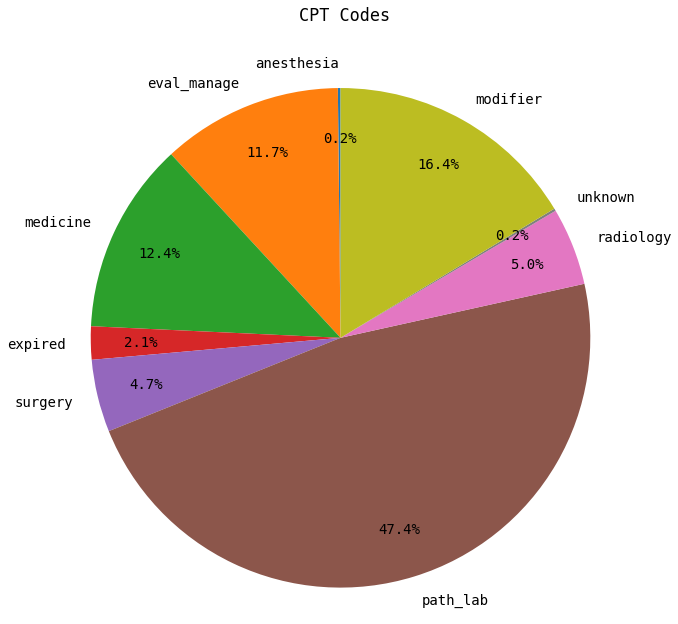

In [48]:
hlpr.pie_chart(code_dict.keys(), cpt, 'code_cat', 'CPT Codes', figsize = (10, 10))

In [49]:
# add counts of CPT categories for each day/patient combination
cpt_wide = cpt.copy()
cpt_wide = (cpt_wide.drop(columns=['cpt_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

In [50]:
# add 'cpt_' prefix to all columns
cols = cpt_wide.columns[~cpt_wide.columns.str.contains('ruid|event_date')]
cpt_wide.rename(columns = dict(zip(cols, 'cpt_' + cols)), inplace=True)
cpt_wide.head()

code_cat             cpt_anesthesia  cpt_eval_manage  cpt_expired  \
ruid     event_date                                                 
50135262 01/09/2005             0.0              1.0          0.0   
         02/08/2007             0.0              1.0          2.0   
         02/09/2007             0.0              2.0          1.0   
         02/10/2007             0.0              1.0          0.0   
         02/11/2007             0.0              1.0          0.0   

code_cat             cpt_medicine  cpt_modifier  cpt_path_lab  cpt_radiology  \
ruid     event_date                                                            
50135262 01/09/2005           1.0           0.0           0.0            0.0   
         02/08/2007           4.0           2.0          10.0            4.0   
         02/09/2007           0.0           3.0           9.0            5.0   
         02/10/2007           7.0           2.0           2.0            0.0   
         02/11/2007           2.0           1.0           2.0            0.0   

code_cat             cpt_surgery  cpt_unknown  
ruid     event_date                            
50135262 01/09/2005          0.0          0.0  
         02/08/2007          0.0          0.0  
         02/09/2007          2.0          0.0  
         02/10/2007          0.0          0.0  
         02/11/2007          0.0          0.0

In [51]:
cpt_wide.reset_index(inplace=True)
cpt_wide.head()

code_cat,ruid,event_date,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,cpt_unknown
0,50135262,01/09/2005,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,50135262,02/08/2007,0.0,1.0,2.0,4.0,2.0,10.0,4.0,0.0,0.0
2,50135262,02/09/2007,0.0,2.0,1.0,0.0,3.0,9.0,5.0,2.0,0.0
3,50135262,02/10/2007,0.0,1.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0
4,50135262,02/11/2007,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0


In [52]:
cpt_wide.tail()

code_cat,ruid,event_date,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,cpt_unknown
576803,53736422,12/06/2006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576804,53736422,12/25/2007,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
576805,53736423,04/23/2006,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
576806,53736423,04/24/2006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
576807,53736423,04/25/2006,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0


In [53]:
cpt_wide['event_date'] = pd.to_datetime(cpt_wide['event_date'])

In [54]:
cpt_wide.to_pickle(dir + 'cpt_wide.pkl')

# Medications

In [55]:
med[60:80]

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
4978,50135262,01/25/2015,omeprazole,NaN,20mg,orally,NaN,daily,NaN
5059,50135262,01/25/2015,ondansetron,NaN,4mg,po,NaN,NaN,NaN
5118,50135262,01/25/2015,oxygen,NaN,2L,NaN,NaN,NaN,NaN
6110,50135262,01/25/2015,zonisamide,NaN,100mg,po,1 cap,q 12 hours,NaN
6109,50135262,01/25/2015,zonisamide,NaN,100mg,po,NaN,q 12 hours,NaN
15,50135262,02/08/2007,ARIPIPRAZOLE: ABILIFY,NaN,NaN,PO,10 MG,QDAY 08,NaN
16,50135262,02/08/2007,ARIPIPRAZOLE: ABILIFY,NaN,NaN,PO,10.00000 MG,QDAY 08,NaN
87,50135262,02/08/2007,BISACODYL SUPPOSITORY,NaN,NaN,PR,10 MG,Q48H,NaN
88,50135262,02/08/2007,BISACODYL SUPPOSITORY,NaN,NaN,PR,10.00000 MG,Q48H,NaN
94,50135262,02/08/2007,BUPROPION: WELLBUTRIN,NaN,NaN,PO,100 MG,BID,NaN


In [56]:
med[-10:]

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
13544415,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.50000 """"",ONCE,NaN
13544417,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1 MG,ONCE,NaN
13544418,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1.00000 MG,ONCE,NaN
13544420,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5 MCG,ONCE,NaN
13544421,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5.00000 MCG,ONCE,NaN
13544416,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,NaN,NaN,TOPICAL,NaN,ONCE,NaN
13544419,53736423,11/17/2014,Polysporin,ointment,NaN,NaN,NaN,NaN,NaN
13544422,53736423,11/17/2014,Vyvanse,NaN,NaN,NaN,NaN,daily,NaN
13544423,53736423,11/17/2014,antibiotic,ointment,NaN,NaN,NaN,NaN,NaN
13544424,53736423,11/17/2014,tetracaine,NaN,3ml,topical,NaN,NaN,NaN


There are significant duplicates of numeric rows where a ".00000" is added to `dose_amt`. Given that this is likely a coding error (e.g., even a vaccine was administered at 5 and 5.00000 for the same patient on the same, which wouldn't happen), I'm removing all rows with the ".00000" in the dose by first removing the ".00000" then looking for duplicates. I already sorted values during loading of data. 

In [57]:
med2 = med.copy()
med2.dose_amt = med2.dose_amt.str.replace('.00000', '')
med2.drop_duplicates(inplace=True)

In [58]:
print("Removed {diff} of {orig} rows ({perc}%).".format(
    diff=med.shape[0]-med2.shape[0], orig=med.shape[0], 
    perc=round((med.shape[0]-med2.shape[0])/med.shape[0]*100, 2)))
med2.shape

Removed 509254 of 13544425 rows (3.76%).


(13035171, 9)

In [59]:
# make new columns to match api for RxNorm
med2.rename(columns={'drug_name': 'DrugNameWithoutDose',
                    'drug_form': 'DosageForm'}, 
            inplace=True)

# inconsistencies in whether dose_amt vs. drug_strength contains the actual strength
# if drug_strength is missing or if dose_amt contains an "mg" use the dose_amt veriable
med2['StrengthText'] = np.where((med2.drug_strength.isnull() | 
                                 med2.dose_amt.str.contains('mg', case=False)), 
                                med2.dose_amt,
                                med2.drug_strength)

# need to add a blank 'DrugUnit' as it's already included in 'dose_amt'
med2['DrugUnit'] = np.NaN

med2.head()

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,dose_amt,drug_freq,duration,StrengthText,DrugUnit
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN,15mg,NaN
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN,15mg,NaN
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN,100mg,NaN
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN,500mg,NaN
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN,81mg,NaN


### Convert Strings to Standardized RxNorm Concept Unique Identifiers (CUIs)

In [60]:
# only needs to be run once
#DatasetCreation.structured_elements2rxcui(med2)

In [61]:
cuis = pd.read_csv(config.out_dir + 'structured_elements_to_rxcui.csv')
print(cuis.shape)
cuis.head()

(520595, 41)


,unique_combo,rxcui1,rxcui2,rxcui3,rxcui4,rxcui5,rxcui6,rxcui7,rxcui8,rxcui9,...,rxcui31,rxcui32,rxcui33,rxcui34,rxcui35,rxcui36,rxcui37,rxcui38,rxcui39,rxcui40
0,abilify 15mg pill,1165950.0,576004.0,352308.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abilify 15mg,576004.0,352308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,amantadine 100mg,849395.0,849388.0,849389.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,amoxicillin 500mg,317616.0,308191.0,308192.0,562927.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,asa 81mg,747234.0,572166.0,315431.0,979117.0,847089.0,1189780.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert RxNorm CUIs to MeSH Drug Classes

In [62]:
# only needs to be run once
#DatasetCreation.cui2class(cuis)

In [63]:
# load classes corresponding to each cui
classes = pd.read_csv(config.out_dir + 'cui2class.csv')
print(classes.shape)

# drop rows with no corresponding categories (i.e., must contain rxcui & at least 1 category)
classes.dropna(thresh=2, inplace=True)
print(classes.shape)
classes.head()

(71697, 18)
(37885, 18)


/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
9,38,Hormone Antagonists,Antiparkinson Agents,Dopamine Agonists,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,44,Protective Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,97,Cytochrome P-450 CYP2C19 Inhibitors,Platelet Aggregation Inhibitors,Purinergic P2Y Receptor Antagonists,Fibrinolytic Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,99,Antifibrinolytic Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,103,"Antimetabolites, Antineoplastic",Immunosuppressive Agents,Antimetabolites,Nucleic Acid Synthesis Inhibitors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
classes.tail()

,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
71687,2099132,"Anesthetics, Local",Contrast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71690,2099296,Laxatives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71691,2099326,Bone Density Conservation Agents,Vitamins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71692,2099327,Bone Density Conservation Agents,Vitamins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71694,2099360,Anti-Inflammatory Agents,Glucocorticoids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine All Medication Information

In [65]:
# add "unique_combo" column to original meds for merging
med2['unique_combo'] = api_rxnorm.make_string(med2)
med2.head()

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,dose_amt,drug_freq,duration,StrengthText,DrugUnit,full,unique_combo
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN,15mg,NaN,abilify%2015mg%20pill%20,abilify%2015mg%20pill%20
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN,15mg,NaN,abilify%2015mg%20,abilify%2015mg%20
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN,100mg,NaN,amantadine%20100mg%20,amantadine%20100mg%20
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN,500mg,NaN,amoxicillin%20500mg%20,amoxicillin%20500mg%20
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN,81mg,NaN,asa%2081mg%20,asa%2081mg%20


In [66]:
# replace "%20" with space (because not making API calls here)
med2.drop(columns='full', inplace=True)
med2.unique_combo = med2.unique_combo.str.replace('%20', ' ')

In [67]:
med2[:10]

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,dose_amt,drug_freq,duration,StrengthText,DrugUnit,unique_combo
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN,15mg,NaN,abilify 15mg pill
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN,15mg,NaN,abilify 15mg
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN,100mg,NaN,amantadine 100mg
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN,500mg,NaN,amoxicillin 500mg
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN,81mg,NaN,asa 81mg
1921,50135262,01/09/2005,benadryl,NaN,50mg,po,NaN,nightly,NaN,50mg,NaN,benadryl 50mg
2425,50135262,01/09/2005,depakote er,NaN,250mg,po,NaN,nightly,NaN,250mg,NaN,depakote er 250mg
2831,50135262,01/09/2005,famotidine,NaN,20mg,po,NaN,twice daily,NaN,20mg,NaN,famotidine 20mg
3257,50135262,01/09/2005,haldol,NaN,NaN,swallow,NaN,NaN,NaN,NaN,NaN,haldol
3281,50135262,01/09/2005,hctz,NaN,25mg,po,NaN,daily,NaN,25mg,NaN,hctz 25mg


In [68]:
med2[-10:]

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,dose_amt,drug_freq,duration,StrengthText,DrugUnit,unique_combo
13544343,53736422,12/25/2007,systane,NaN,NaN,NaN,NaN,qid,NaN,NaN,NaN,systane
13544414,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.5 """"",ONCE,NaN,"0.5 """"",NaN,"ERYTHROMYCIN EYE OINTMENT: 0.5 """""
13544415,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.50000 """"",ONCE,NaN,"0.50000 """"",NaN,"ERYTHROMYCIN EYE OINTMENT: 0.50000 """""
13544417,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1 MG,ONCE,NaN,1 MG,NaN,PHYTONADIONE INJ:AQUA-MEPHYTON 1 MG
13544420,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5 MCG,ONCE,NaN,5 MCG,NaN,RECOMBIVAX HB (PEDIATRIC): 5 MCG
13544416,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,NaN,NaN,TOPICAL,NaN,ONCE,NaN,NaN,NaN,LIDOCAINE/EPINEPHRI/TETRACAINE
13544419,53736423,11/17/2014,Polysporin,ointment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Polysporin ointment
13544422,53736423,11/17/2014,Vyvanse,NaN,NaN,NaN,NaN,daily,NaN,NaN,NaN,Vyvanse
13544423,53736423,11/17/2014,antibiotic,ointment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,antibiotic ointment
13544424,53736423,11/17/2014,tetracaine,NaN,3ml,topical,NaN,NaN,NaN,3ml,NaN,tetracaine 3ml


In [69]:
# add just first rxcui (for now)
med_cuis = (med2[['ruid', 'entry_date', 'unique_combo']]
            .merge(cuis[['unique_combo', 'rxcui1']], 
                   how='left', 
                   on='unique_combo'))
med_cuis.head()

,ruid,entry_date,unique_combo,rxcui1
0,50135262,01/09/2005,abilify 15mg pill,1165950.0
1,50135262,01/09/2005,abilify 15mg,576004.0
2,50135262,01/09/2005,amantadine 100mg,849395.0
3,50135262,01/09/2005,amoxicillin 500mg,317616.0
4,50135262,01/09/2005,asa 81mg,747234.0


In [70]:
med_cuis.tail()

,ruid,entry_date,unique_combo,rxcui1
13035166,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,1866387.0
13035167,53736423,11/17/2014,Polysporin ointment,54955.0
13035168,53736423,11/17/2014,Vyvanse,1187603.0
13035169,53736423,11/17/2014,antibiotic ointment,204602.0
13035170,53736423,11/17/2014,tetracaine 3ml,340065.0


In [71]:
# rename rxcui for merge
med_cuis.rename(columns={'rxcui1': 'rxcui'}, inplace=True)

med_classes = med_cuis.merge(classes, how='left', on='rxcui')
med_classes.head()

,ruid,entry_date,unique_combo,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,...,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
0,50135262,01/09/2005,abilify 15mg pill,1165950.0,Antipsychotic Agents,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50135262,01/09/2005,abilify 15mg,576004.0,Antipsychotic Agents,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50135262,01/09/2005,amantadine 100mg,849395.0,Dopamine Agents,"Analgesics, Non-Narcotic",Antiviral Agents,Antiparkinson Agents,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50135262,01/09/2005,amoxicillin 500mg,317616.0,Anti-Bacterial Agents,beta-Lactamase Inhibitors,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50135262,01/09/2005,asa 81mg,747234.0,Antipyretics,Platelet Aggregation Inhibitors,Fibrinolytic Agents,"Anti-Inflammatory Agents, Non-Steroidal",Cyclooxygenase Inhibitors,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
med_classes.tail()

,ruid,entry_date,unique_combo,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,...,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
13035166,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,1866387.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035167,53736423,11/17/2014,Polysporin ointment,54955.0,Anti-Bacterial Agents,"Anti-Infective Agents, Local",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035168,53736423,11/17/2014,Vyvanse,1187603.0,Dopamine Uptake Inhibitors,Central Nervous System Stimulants,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035169,53736423,11/17/2014,antibiotic ointment,204602.0,Anti-Bacterial Agents,Protein Synthesis Inhibitors,"Anti-Infective Agents, Local",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035170,53736423,11/17/2014,tetracaine 3ml,340065.0,"Anesthetics, Local",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
med_classes.shape

(13035171, 21)

In [74]:
# break dataframe into subsections to reduce memory burden (& increase speed)
batch_size = 1000000

batches = [med_classes[i * batch_size:(i + 1) * batch_size] \
           for i in range((len(med_classes) + batch_size - 1) // batch_size)]

In [75]:
if config.print_status:
    counter = 0
    print('Created ' + str(len(batches)) + ' batches.')
    
med_classes_long = pd.DataFrame()

for i in range(len(batches)):
    if config.print_status:
        counter += 1
        print('Starting batch # ' + str(counter))
    
    # melt data frame so all categories collapsed into 1 column
    temp = pd.melt(batches[i], id_vars=['ruid', 'entry_date', 'unique_combo', 'rxcui'])
    
    # append to existing dataframe
    med_classes_long = med_classes_long.append(temp, sort=True)

Created 14 batches.
Starting batch # 1
Starting batch # 2
Starting batch # 3
Starting batch # 4
Starting batch # 5
Starting batch # 6
Starting batch # 7
Starting batch # 8
Starting batch # 9
Starting batch # 10
Starting batch # 11
Starting batch # 12
Starting batch # 13
Starting batch # 14


In [76]:
# melt data frame so all categories collapsed into 1 column
med_classes = pd.melt(med_classes, id_vars=['ruid', 'entry_date', 'unique_combo', 'rxcui'])
# drop values where category was missing (which is primarily done for cat2 & higher)
med_classes.dropna(inplace=True)
med_classes.head()

,ruid,entry_date,unique_combo,rxcui,variable,value
0,50135262,01/09/2005,abilify 15mg pill,1165950.0,cat1,Antipsychotic Agents
1,50135262,01/09/2005,abilify 15mg,576004.0,cat1,Antipsychotic Agents
2,50135262,01/09/2005,amantadine 100mg,849395.0,cat1,Dopamine Agents
3,50135262,01/09/2005,amoxicillin 500mg,317616.0,cat1,Anti-Bacterial Agents
4,50135262,01/09/2005,asa 81mg,747234.0,cat1,Antipyretics


In [77]:
med_classes.shape

(24830306, 6)

In [78]:
# This file contains the unique medications for each patient-day along with the
# first (best) RxCUI and all MeSH classess associated with that first CUI.
# Because an RxCUI can have multiple classes, the "variable" column indicates 
# which category the value belonged to (note: this is not ranked, all categories 
# are equally representative for the RxCUI)

#med_classes.to_pickle(dir + 'med_classes.pkl')
med_classes.to_csv(dir + 'med_classes.csv')

### Drop RUIDs of Patients not in Final Cohort

In [79]:
#med_classes = pd.read_csv(dir + './med_classes.pkl')
#med_classes.head()

In [80]:
final_ruids = adt_cms_final.ruid.unique()
len(final_ruids)

5664

In [81]:
# break dataframe into subsections to prevent timeout
batch_size = 500
ruids = [final_ruids[i * batch_size:(i + 1) * batch_size] \
         for i in range((len(final_ruids) + batch_size - 1) // batch_size)]

In [82]:
if config.print_status:
    counter = 0
    print('Created ' + str(len(ruids)) + ' batches.')
    
med_classes_final_ruids = pd.DataFrame()

for i in range(len(ruids)):
    if config.print_status:
        counter += 1
        print('Starting batch # ' + str(counter))
    
    temp = med_classes[med_classes['ruid'].isin(ruids[i])]
    
    temp = (temp.drop(columns=['rxcui', 'variable'])
                .groupby(['ruid', 'entry_date', 'value'])
                .size()
                .unstack()
                .fillna(0))
    
    med_classes_final_ruids = med_classes_final_ruids.append(temp, sort=True)

Created 12 batches.
Starting batch # 1
Starting batch # 2
Starting batch # 3
Starting batch # 4
Starting batch # 5
Starting batch # 6
Starting batch # 7
Starting batch # 8
Starting batch # 9
Starting batch # 10
Starting batch # 11
Starting batch # 12


In [83]:
# add 'med_' prefix to all columns
cols = med_classes_final_ruids.columns[~med_classes_final_ruids.columns.str.contains('ruid|event_date')]
med_classes_final_ruids.rename(columns = dict(zip(cols, 'med_' + cols)), inplace=True)
med_classes_final_ruids.head()

med_14-alpha Demethylase Inhibitors  \
ruid     entry_date                                        
50135262 01/09/2005                                  0.0   
         01/15/2007                                  0.0   
         01/25/2015                                  0.0   
         02/08/2007                                  0.0   
         02/09/2007                                  0.0   

                     med_5-alpha Reductase Inhibitors  \
ruid     entry_date                                     
50135262 01/09/2005                               0.0   
         01/15/2007                               0.0   
         01/25/2015                               0.0   
         02/08/2007                               0.0   
         02/09/2007                               0.0   

                     med_Abortifacient Agents, Nonsteroidal  \
ruid     entry_date                                           
50135262 01/09/2005                                     0.0   
         01/15/2007                                     0.0   
         01/25/2015                                     0.0   
         02/08/2007                                     0.0   
         02/09/2007                                     0.0   

                     med_Acetaldehyde Dehydrogenase Inhibitors  \
ruid     entry_date                                              
50135262 01/09/2005                                        NaN   
         01/15/2007                                        NaN   
         01/25/2015                                        NaN   
         02/08/2007                                        NaN   
         02/09/2007                                        NaN   

                     med_Acetylcholine Release Inhibitors  \
ruid     entry_date                                         
50135262 01/09/2005                                   0.0   
         01/15/2007                                   0.0   
         01/25/2015                                   0.0   
         02/08/2007                                   0.0   
         02/09/2007                                   0.0   

                     med_Acid Sensing Ion Channel Blockers  \
ruid     entry_date                                          
50135262 01/09/2005                                    0.0   
         01/15/2007                                    0.0   
         01/25/2015                                    0.0   
         02/08/2007                                    0.0   
         02/09/2007                                    0.0   

                     med_Adenosine A2 Receptor Agonists  \
ruid     entry_date                                       
50135262 01/09/2005                                 0.0   
         01/15/2007                                 0.0   
         01/25/2015                                 0.0   
         02/08/2007                                 0.0   
         02/09/2007                                 0.0   

                     med_Adenosine Deaminase Inhibitors  \
ruid     entry_date                                       
50135262 01/09/2005                                 NaN   
         01/15/2007                                 NaN   
         01/25/2015                                 NaN   
         02/08/2007                                 NaN   
         02/09/2007                                 NaN   

                     med_Adjuvants, Anesthesia  med_Adjuvants, Immunologic  \
ruid     entry_date                                                          
50135262 01/09/2005                        0.0                         0.0   
         01/15/2007                        0.0                         0.0   
         01/25/2015                        0.0                         0.0   
         02/08/2007                        1.0                         0.0   
         02/09/2007                        0.0                         0.0   

                                 ...                med_U

In [84]:
med_classes_final_ruids.shape

(505474, 339)

In [85]:
med_classes_final_ruids.reset_index(inplace=True)

In [86]:
med_classes_final_ruids.head()

,ruid,entry_date,med_14-alpha Demethylase Inhibitors,med_5-alpha Reductase Inhibitors,"med_Abortifacient Agents, Nonsteroidal",med_Acetaldehyde Dehydrogenase Inhibitors,med_Acetylcholine Release Inhibitors,med_Acid Sensing Ion Channel Blockers,med_Adenosine A2 Receptor Agonists,med_Adenosine Deaminase Inhibitors,...,med_Uncoupling Agents,med_Uricosuric Agents,med_Urological Agents,med_Vasoconstrictor Agents,med_Vasodilator Agents,med_Viscosupplements,med_Vitamin B Complex,med_Vitamins,med_Voltage-Gated Sodium Channel Blockers,med_beta-Lactamase Inhibitors
0,50135262,01/09/2005,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,50135262,01/15/2007,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50135262,01/25/2015,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,50135262,02/08/2007,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,50135262,02/09/2007,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
med_classes_final_ruids.tail()

,ruid,entry_date,med_14-alpha Demethylase Inhibitors,med_5-alpha Reductase Inhibitors,"med_Abortifacient Agents, Nonsteroidal",med_Acetaldehyde Dehydrogenase Inhibitors,med_Acetylcholine Release Inhibitors,med_Acid Sensing Ion Channel Blockers,med_Adenosine A2 Receptor Agonists,med_Adenosine Deaminase Inhibitors,...,med_Uncoupling Agents,med_Uricosuric Agents,med_Urological Agents,med_Vasoconstrictor Agents,med_Vasodilator Agents,med_Viscosupplements,med_Vitamin B Complex,med_Vitamins,med_Voltage-Gated Sodium Channel Blockers,med_beta-Lactamase Inhibitors
505469,53736422,11/29/2008,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
505470,53736422,12/03/2008,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
505471,53736422,12/06/2006,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
505472,53736422,12/11/2008,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
505473,53736422,12/25/2007,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [88]:
len(med_classes_final_ruids.ruid.unique())

5658

In [89]:
med_classes_final_ruids['entry_date'] = pd.to_datetime(med_classes_final_ruids['entry_date'])

In [90]:
# SAVE
med_classes_final_ruids.to_pickle(dir + 'med_classes_final_ruids.pkl')